## Final Report:
### Using past medal winnings to determine the winner in select summer olympic events
by Jake Schaeffer

In [44]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict

### Introduction:
By using data about the summer olympics dating back to the first modern olympiad, I will create a model that attempts to predict the winning country of track & field and swimming events using the historical data of which countries medaled.

### Data
This data contains information on who got on the podium in all summer olympic events since the beginning of the modern olympic era to the games played in London in 2012. Each observation represents an athlete that podiumed, including multiple observations for teams. When I perform classification, I will use select parts of this data to attempt to predict which country will get the gold in all swimming and track &field events.

In [21]:
df = pd.read_csv("./data/summer.csv")

### Data Preparation
First, I will make all variables that are not the year categoricals. Then I will take out two unneeded variables: sport, which is a category used for events that is extraneous, and athlete, which is too varied to offer any meaning statistically. Then I got rid of duplicate observations. These come from teams that podiumed where there are multiple athletes. By dropping duplicates, we have only one observation for each team that podiumed.

In [22]:
for col in df.columns[1:]:
    df[col] = pd.Categorical(df[col])
df = df.drop("Sport", axis = 1).drop("Athlete",axis  =1)
df = df.drop_duplicates()

Next, I calculate a weight for each observation. this is a very rudimentary way of quantifying how good a country is at an event. I weight the medals using New York Times' point system of 4,2,1 for Gold Silver and Bronze. I weight how recent the medal was won by weighting each older olympiad 2/3 that of the previous. So 2012 has a weight of 1, 2008- 2/3. 2004- 4/9, and so on. This is done to value a country's past dominance in an event, but also goes down as we go farther back in time due country's dominance changing over time. With this system, most observations from before the 1990s are not very important in the weighting. Considering that the events I am looking at are mostly of single athletes, this makes sense because athletes that may have won a country medals in the past have likely retired.

In [23]:
df["yearWeight"] = (2/3)**(29 - (df["Year"] - 1896)/4)
df["medalWeight"] = 0
def weightMedal (row):
    if row['Medal'] == "Gold" :
        return 4
    if row["Medal"] == "Silver":
        return 2
    if row['Medal'] == "Bronze" :
        return 1
df['medalWeight'] = df.apply(lambda row: weightMedal(row), axis=1)
df["Weight"] = df['medalWeight'] * df["yearWeight"]

We can predict that total golds is likely tied to the countrie's total medal weight score....

Text(0.5, 1.0, 'Country podium score vs number of golds')

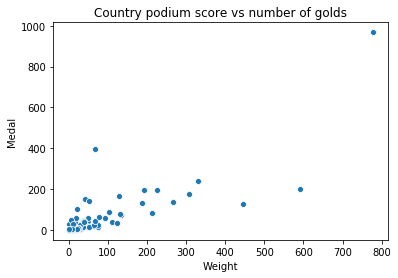

In [42]:
totalWeights = df.groupby("Country").sum()["Weight"]
totalGolds = df[df["Medal"] == "Gold"].groupby("Country").count()["Medal"]
fig = sns.scatterplot(x = totalWeights,y = totalGolds)
fig.set_title("Country podium score vs number of golds")

1896 is not included because there was a large difference in the events played in that year compared to the 1900s. Here I also create a dataframe called "scores" that contains each country's "weight" in each event. This is used for our input when modeling.

In [24]:
df = df[df.Year != 1896]
allscores  = df.groupby(["Country","Event"]).sum()["Weight"]
countries = df["Country"].drop_duplicates().dropna()
events = df[(df["Discipline"] == "Swimming") |(df["Discipline"] == "Athletics")].Event.drop_duplicates()
scores = pd.DataFrame(index = events,columns = countries)
for country in countries:
    for event in events:
        scores.loc[event,country] = allscores[country,event]
for event in scores.index:
    if scores.loc[event].count() < 20:
        scores.drop(event,inplace = True)

In order to get the target labels, I used the most recent year as "truth". the countries that one gold in each event are put into y.

In [28]:
londonGolds = df[(df["Gender"] == "Men") &(df["Medal"] == "Gold") &(df["Year"] == 2012) & ((df["Discipline"] == "Swimming")|(df["Discipline"] == "Athletics"))]
y = londonGolds[['Event','Country']]
scores.index = scores.index.astype(str)
scores.columns = scores.columns.astype(str)
Xy = pd.merge(scores, y, on= "Event")
Xy = Xy.set_index("Event")
X = Xy.iloc[:,:-1]
y = Xy.iloc[:,-1]
X = X.fillna(0)

### Model

I found that using Naive Bayes with a lot of smoothing and using a uniform prior resulted in the best prediction accuracy. comparing the accuracy of different methods with different parameters, I found that naive bayes made since given the form of the data, and more smoothing essentially means we are picking the most likely winner each time, which is usually going to be right more often then a less likely pick. This is due to some countries having absolute dominance in some events.

In [59]:
clf = MultinomialNB(alpha = 3,fit_prior = False)
y_pred = cross_val_predict(clf,X,y)
print("accuracy of the Naive Bayes model: {:.2F}%".format(accuracy_score(y,y_pred)*100))
clf.fit(X,y)

accuracy of the Naive Bayes model: 34.48%


C:\Users\Jake\Anaconda3\envs\csci349\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


MultinomialNB(alpha=3, class_prior=None, fit_prior=False)

### Performance Results
We see from the results that due to the number of possible results and how much can change between olympiads, there are many mistakes, but none that are consistent. Overall I would say a 34% accuracy rate is not bad considering the variability of the inputs and the arbitraryness of the weighting system.

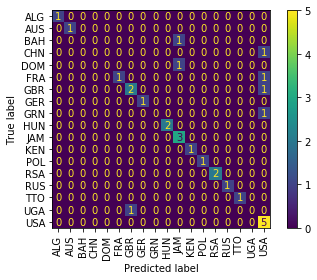

In [62]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf,X,y,xticks_rotation = "vertical")

### Discussion

I made the mistake of picking a data set that did not lend itself to classification, and thus spent hours pulling my hair out trying to figure out what to classify. My result was something I am not happy with, as it isn't very useful. However, I did find that I like making incites from data, but maybe in more of a tableau way than in a machine learning way. I was not surprised that most methods didn't offer very good accuracy of classification, as the task would be hard for anyone given how much things change between olympiads. I think I would try changing the weighting system and treating that as a parameter would be a way to figure out how to better classify. In this I did not consider that I could use the weighting system as a parameter until I had already coded everything.

### Conclusions

I found that it is very difficult to predict what country will win an olympic event. ESPECIALLY if it's an individual event. Individual athletes come and go so quickly, and talents may come from any different country. I think that this shows one of the beauties of the olympics - that there is no guarantee that any country will win in any sport. 